In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import fastai.vision.all as fastai
from ptflops import get_model_complexity_info

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision.transforms import ToTensor, ToPILImage
from torchvision import transforms
import torch_lr_finder
import timm

import numpy as np
import matplotlib.pyplot as plt

import cv2

from icecream import ic
from tqdm.notebook import tqdm

from pathlib import Path

In [3]:
# path = Path(str(fastai.untar_data(fastai.URLs.CAMVID_TINY)) + '_all_same')
path = fastai.untar_data(fastai.URLs.CAMVID_TINY)
codes = np.loadtxt(path/'codes.txt', dtype=str)
fnames = fastai.get_image_files(path/"images")
def label_func(fn): return path/"labels"/f"{fn.stem}_P{fn.suffix}"
dls = fastai.SegmentationDataLoaders.from_label_func(
    path, bs=8, fnames = fnames, label_func = label_func, codes = codes
)
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

/home/nb/miniforge3/envs/ml/lib/python3.9/site-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


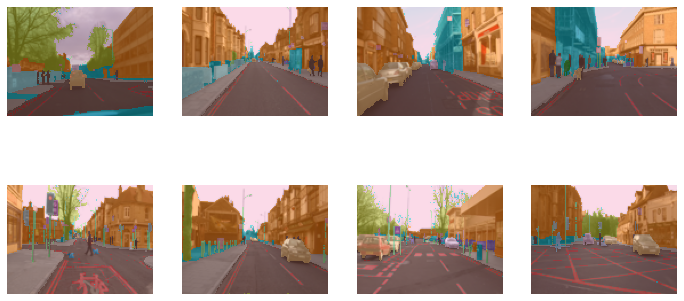

In [4]:
dls[0].show_batch()

In [5]:
def acc_camvid(inp, targ):
    targ = targ.squeeze(1)
    mask = targ != void_code
    return (inp.argmax(dim=1)[mask]==targ[mask]).float().mean()

DynamicUnet(
  19.957 M, 100.000% Params, 5.941 GMac, 100.000% MACs, 
  (layers): ModuleList(
    19.957 M, 100.000% Params, 5.941 GMac, 100.000% MACs, 
    (0): Sequential(
      0.017 M, 0.085% Params, 0.9 GMac, 15.149% MACs, 
      (0): Conv2d(0.0 M, 0.000% Params, 0.029 GMac, 0.486% MACs, 3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(0.0 M, 0.001% Params, 0.0 GMac, 0.007% MACs, 64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(0.0 M, 0.000% Params, 0.0 GMac, 0.003% MACs, inplace=True)
      (3): MaxPool2d(0.0 M, 0.000% Params, 0.0 GMac, 0.003% MACs, kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        0.001 M, 0.004% Params, 0.171 GMac, 2.874% MACs, 
        (0): BasicBlock(
          0.0 M, 0.001% Params, 0.057 GMac, 0.958% MACs, 
          (conv1): Conv2d(0.0 M, 0.000% Params, 0.028 GMac, 0.477% MACs, 64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)

epoch,train_loss,valid_loss,acc_camvid,time
0,2.766604,2.589099,0.274944,00:04


epoch,train_loss,valid_loss,acc_camvid,time
0,1.760534,1.715238,0.579108,00:02
1,1.530342,1.412557,0.618527,00:02
2,1.393752,1.310512,0.634404,00:02
3,1.269620,1.155758,0.744074,00:02
4,1.139803,0.987572,0.785024,00:02
5,1.019811,0.880185,0.795940,00:02
6,0.921704,0.862356,0.808607,00:02
7,0.841215,0.846839,0.814801,00:02
8,0.774552,0.822978,0.817349,00:02
9,0.720976,0.823538,0.817793,00:02


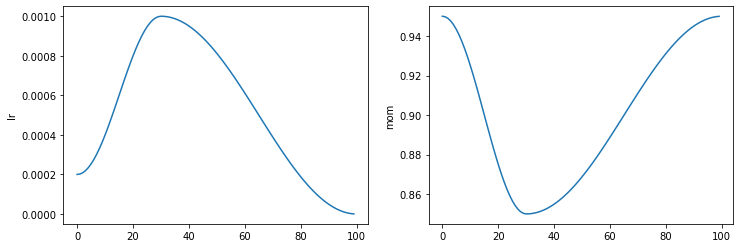

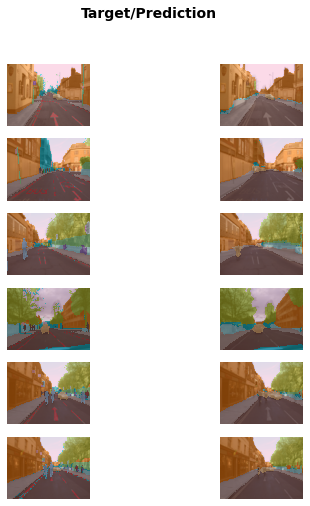

In [6]:
def fastai_learn():
    learn = fastai.unet_learner(dls, fastai.resnet34, metrics=acc_camvid)
    get_model_complexity_info(learn.model, (3, 96, 128), as_strings=True, print_per_layer_stat=True, verbose=False)
    # learn.summary()
    learn.fine_tune(10)
    learn.recorder.plot_sched()
    learn.show_results(max_n=6, figsize=(7,8))
fastai_learn()

In [7]:
def swap_rb(im):
    return im[:,:,[2,1,0]]

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def denormalized_imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.detach().cpu().numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    # inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

class CamvidDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir: Path, transform=None):
        self.root_dir = root_dir
        image_files = list((root_dir/'images').glob('*.png'))
        label_files = [root_dir/"labels"/f"{fn.stem}_P{fn.suffix}" for fn in image_files]
        self.inputs = list(zip(image_files, label_files))

        self.transform = transforms.Compose([
            transforms.ToTensor(),
            # transforms.Lambda(lambda x: x.to(device)),
            # Normalize as if it was a uniform distribution
            # RandomResizedCrop(128, min_scale=0.35), batch_tfms=Normalize.from_stats(*imagenet_stats))
            # transforms.Resize((128,128)),
            # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            # transforms.RandomResizedCrop(128, scale=(0.35, 1.0)),
        ])

        # No need for normalization, it expects the class index.
        self.target_transform = transforms.Compose([
            transforms.Lambda(lambda x: torch.from_numpy(x).long()),
            # transforms.ToTensor(),
            # transforms.Lambda(lambda x: x.to(device)),
        ])

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        path_img, path_labels = self.inputs[idx]
        img = cv2.imread(str(path_img), cv2.IMREAD_COLOR)
        labels = cv2.imread(str(path_labels), cv2.IMREAD_GRAYSCALE)
        img = swap_rb(img)
        if self.transform:
            img = self.transform(img)
        if self.target_transform:
            labels = self.target_transform(labels)
        return img, labels

# dataset = CamvidDataset (path)

# train_ds, val_ds = torch.utils.data.random_split(dataset, (80, 20))
# train_dataloader = torch.utils.data.DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=0)
# val_dataloader = torch.utils.data.DataLoader(val_ds, batch_size=8, shuffle=False)

train_dataloader = dls[0]
val_dataloader = dls[1]

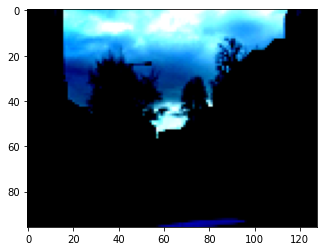

In [8]:
b0 = next(iter(train_dataloader))
denormalized_imshow(b0[0][0])

In [9]:
class UnetBlock(nn.Module):
    def __init__(self, left_features, down_features, out_features):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(left_features + down_features, down_features, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(down_features),
            nn.ReLU(),

            nn.Conv2d(down_features, out_features, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_features),
            nn.ReLU(),
        )

    def forward(self, left, down):
        down_upsampled = F.interpolate(down, scale_factor=2)
        x = torch.cat((down_upsampled, left), dim=1)
        return self.block (x)


class MyUnet(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.encoder = timm.create_model('resnet18', features_only=True, pretrained=True)

        # {'module': 'act1', 'num_chs': 64, 'reduction': 2},
        # {'module': 'layer1', 'num_chs': 64, 'reduction': 4},
        # {'module': 'layer2', 'num_chs': 128, 'reduction': 8},
        # {'module': 'layer3', 'num_chs': 256, 'reduction': 16},
        # {'module': 'layer4', 'num_chs': 512, 'reduction': 32}]

        # act1 torch.Size([8, 64, 48, 64]),
        # layer1 torch.Size([8, 64, 24, 32]),
        # layer2 torch.Size([8, 128, 12, 16]),
        # X torch.Size([8, 256, 6, 8]),
        # X torch.Size([8, 512, 3, 4])

        self.dec2 = UnetBlock(128,256,out_features=128)
        self.dec1 = UnetBlock(64,128,  out_features=64)
        self.dec0 = UnetBlock(64,64,  out_features=64)

        self.bottom = nn.Sequential(
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),            
            nn.ReLU(),

            nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )

        self.head = nn.Sequential(
            nn.Upsample(scale_factor=2),

            nn.Conv2d(64, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            # 1x1 conv
            nn.Conv2d(64, n_classes, kernel_size=1, padding=0),
        )

    def freeze_encoder(self):
        for p in self.encoder.parameters():
            p.requires_grad = False

    def unfreeze_encoder(self):
        for p in self.encoder.parameters():
            p.requires_grad = True

    def forward(self, img):
        # Ignoring layer 3 and 4, too small.
        act1, layer1, layer2 = self.encoder(img)[:3]
        down2 = self.bottom(layer2)
        x = self.dec2(layer2, down2)
        x = self.dec1(layer1, x)
        x = self.dec0(act1, x)
        return self.head(x)



In [10]:

# def pytorch_custom_training():

# b = next(iter(train_dataloader))
# denormalized_imshow(b[0][0])

EPOCHS = 10

net = MyUnet(len(codes))
net.to(device)
# optimizer = torch.optim.Adam(net.parameters(), lr=3e-4)
# optimizer = torch.optim.SGD(net.parameters(), lr=5e-3, momentum=0.9)
criterion = nn.CrossEntropyLoss()

# get_model_complexity_info(net, (3, 96, 128), as_strings=True, print_per_layer_stat=True, verbose=False)

# lr_finder = torch_lr_finder.LRFinder(net, optimizer, criterion, device=device)
# lr_finder.range_test(train_dataloader, start_lr=1e-5, end_lr=1.0, num_iter=100)
# lr_finder.plot() # to inspect the loss-learning rate graph
# lr_finder.reset() # to reset the model and optimizer to their initial state

# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, steps_per_epoch=len(train_dataloader), epochs=EPOCHS)

def train(epochs, optimizer, scheduler=None):
    pbar = tqdm(range(epochs))
    for epoch in pbar:
        net.train()

        train_loss = 0.0
        for batch in train_dataloader:
            # inputs, targets = (batch[0].to(device), batch[1].to(device))
            inputs, targets = (batch[0].as_subclass(torch.Tensor).to(device), batch[1].as_subclass(torch.Tensor).to(device))
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            train_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if scheduler:
                scheduler.step()
        train_loss /= len(train_dataloader)
                

        def acc_camvid(inp, targ):
            targ = targ.squeeze(1)
            mask = targ != void_code
            return (inp.argmax(dim=1)[mask]==targ[mask]).float().mean()

        net.eval()

        num_correct = 0
        num_evaluated = 0
        val_loss = 0.0
        with torch.no_grad():        
            for batch in val_dataloader:
                inputs, targets = (batch[0].as_subclass(torch.Tensor).to(device), batch[1].as_subclass(torch.Tensor).to(device))
                outputs = net(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
                predicted_classes = torch.argmax(outputs, dim=1)
                mask = targets != void_code
                num_correct += torch.count_nonzero(predicted_classes[mask] == targets[mask]).item()
                num_evaluated += torch.count_nonzero(mask).item()
            val_accuracy = num_correct / num_evaluated
            # val_loss /= len(val_dataloader)
            val_loss /= len(dls[1])
            # ic(num_correct)
            # ic(num_evaluated)
            # ic(val_accuracy)

        pbar.set_postfix({'train_loss': train_loss, 'val_loss': val_loss, 'accuracy': val_accuracy})

optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
net.freeze_encoder()
train(1, optimizer)

optimizer = torch.optim.Adam(net.parameters(), lr=3e-4)
net.unfreeze_encoder()
train(EPOCHS, optimizer, torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, steps_per_epoch=len(train_dataloader), epochs=EPOCHS))

# learn = Learner(dls, net, metrics=accuracy)
# # get_model_complexity_info(learn.model, (3, 224, 224), as_strings=True, print_per_layer_stat=True, verbose=False)    
# display(learn.validate())

# pytorch_custom_training ()

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [11]:
def acc_camvid_adapted_to_fastai(inp, targ):
    targ = targ.as_subclass(torch.Tensor)
    mask = targ != void_code
    return (inp.argmax(dim=1)[mask]==targ[mask]).float().mean()

net.eval()
learn = fastai.Learner(dls, net, metrics=acc_camvid_adapted_to_fastai)
# # get_model_complexity_info(learn.model, (3, 224, 224), as_strings=True, print_per_layer_stat=True, verbose=False)    
# learn.fine_tune(6)
# learn.recorder.plot_sched()
ic(learn.validate())

ic| learn.validate(): [0.9883531332015991, 0.8090962171554565]


(#2) [0.9883531332015991,0.8090962171554565]